In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [76]:
import os
from pathlib import Path

import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from loanapprovalprediction.constants import (
    CATEGORICAL_VARIABLES,
    CONTINUOUS_VARIABLES,
    TARGET,
)

sns.set_theme()

DATA_DIR = Path(os.getcwd()).parent / "data"

In [3]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

## Preprocess data

In [40]:
def preprocess_data(
    data_: pd.DataFrame, 
    scaler: StandardScaler, 
    cont_features: list[str],
    cat_features: list[str],
    fit:bool=False
) -> pd.DataFrame:
    data = data_.reset_index(drop=True)
    if fit:
        X_cont = scaler.fit_transform(data[cont_features])
    else:
        X_cont = scaler.transform(data[cont_features])

    return pd.concat([
        pd.DataFrame(X_cont, columns=cont_features), 
        data[cat_features].apply(pd.Categorical)], axis=1
    )

scaler = StandardScaler()
cont_features = list(set(CONTINUOUS_VARIABLES) - set(["person_age", "cb_person_cred_hist_length"]))
# cont_features = CONTINUOUS_VARIABLES
training, valid = train_test_split(train, test_size=0.2, random_state=42)
X_train = preprocess_data(training, scaler, cont_features=cont_features, cat_features=CATEGORICAL_VARIABLES, fit=True)
X_valid = preprocess_data(valid, scaler, cont_features=cont_features, cat_features=CATEGORICAL_VARIABLES,)
y_train = training[TARGET]
y_valid = valid[TARGET]

X_test = preprocess_data(test, scaler, cont_features=cont_features, cat_features=CATEGORICAL_VARIABLES,)

In [65]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    enable_categorical=True,
    eval_metric="auc",
)
clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_valid, y_valid)],
    verbose=False
)
print(clf.score(X_train, y_train))
print(clf.score(X_valid, y_valid))

0.9636584534060875
0.9488447437974252


In [66]:
y_pred_proba = clf.predict_proba(X_valid)[:, 1]
auc_roc = roc_auc_score(y_valid, y_pred_proba)
auc_roc

np.float64(0.9551557056531441)

In [39]:
from xgboost import XGBClassifier

clf = XGBClassifier(enable_categorical=True)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_valid, y_valid))

0.9602054736124137
0.9473953448716855


In [ ]:
graph = xgb.to_graphviz(clf, num_trees=1)
graph

In [74]:
# preds = clf.predict(X_test)
preds = clf.predict_proba(X_test)[:, 1]
test.assign(loan_status = preds)[["id", TARGET]].to_csv(DATA_DIR / "submission3.csv", index=False)

In [75]:
!kaggle competitions submit -c playground-series-s4e10 -f ../data/submission.csv -m "Submit probabilities"
# !kaggle competitions submit -c playground-series-s4e10 -f ../data/submission.csv -m "Initial submission"

100%|█████████████████████████████████████████| 305k/305k [00:00<00:00, 432kB/s]
Successfully submitted to Loan Approval Prediction

In [ ]:
# Score on initial submission: 0.86906
# Score on submission using Ax-optimized hyperparameters: 0.86842 :(
# score on submission using Ax-optimized hyperparameters and optimizing for AUC: 0.95522

In [ ]:
import pandas as pd
from ax.service.ax_client import AxClient
from sklearn.metrics import roc_auc_score
import numpy as np
from ax.service.utils.instantiation import ObjectiveProperties
# Initialize Ax client
ax_client = AxClient()

# Define the parameters to optimize
ax_client.create_experiment(
    name="xgboost_optimization",
    parameters=[
        {
            "name": "max_depth",
            "type": "range",
            "bounds": [3, 12],
            "value_type": "int",
        },
        {
            "name": "learning_rate",
            "type": "range",
            "bounds": [0.01, 0.3],
            "log_scale": True,
        },
        {
            "name": "min_child_weight",
            "type": "range",
            "bounds": [1, 7],
        },
        {
            "name": "colsample_bytree",
            "type": "range",
            "bounds": [0.3, 1.0],
        },
        {
            "name": "subsample",
            "type": "range",
            "bounds": [0.6, 1.0],
        },
        {
            "name": "n_estimators",
            "type": "range",
            "bounds": [100, 1000],
            "value_type": "int",
        },
        {
            "name": "scale_pos_weight",
            "type": "range",
            "bounds": [1, 10],
        }
    ],
    objectives={
        "auc_roc": ObjectiveProperties(minimize=False),
    }
)

def train_evaluate_xgboost(parameters):
    """Training function that Ax will optimize"""
    # Convert parameters to XGBoost parameters
    xgb_params = {
        "max_depth": int(parameters["max_depth"]),
        "learning_rate": parameters["learning_rate"],
        "min_child_weight": parameters["min_child_weight"],
        "colsample_bytree": parameters["colsample_bytree"],
        "subsample": parameters["subsample"],
        "n_estimators": int(parameters["n_estimators"]),
        "scale_pos_weight": parameters["scale_pos_weight"],
        "enable_categorical": True,
        "early_stopping_rounds": 20,  # Moved here
        "eval_metric": 'auc'  # Moved here
    }
    
    # Initialize and train model
    clf = XGBClassifier(**xgb_params)
    clf.fit(
        X_train, 
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    
    # Get prediction probabilities for AUC-ROC calculation
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    auc_roc = roc_auc_score(y_valid, y_pred_proba)
    
    return auc_roc

# Run optimization
for i in range(50):  # 50 trials
    parameters, trial_index = ax_client.get_next_trial()
    auc_roc = train_evaluate_xgboost(parameters)
    # Note the change in the complete_trial call:
    ax_client.complete_trial(trial_index=trial_index, raw_data={"auc_roc": auc_roc})
    
    if (i + 1) % 10 == 0:  # Print progress every 10 trials
        print(f"Completed {i + 1} trials")

# Get best parameters
best_parameters, metrics = ax_client.get_best_parameters()

# Print best parameters and score
print("\nBest parameters:")
for param, value in best_parameters.items():
    print(f"{param}: {value}")
# print(f"\nBest AUC-ROC: {metrics['auc_roc']}")

# Train final model with best parameters
best_params = {
    "max_depth": int(best_parameters["max_depth"]),
    "learning_rate": best_parameters["learning_rate"],
    "min_child_weight": best_parameters["min_child_weight"],
    "colsample_bytree": best_parameters["colsample_bytree"],
    "subsample": best_parameters["subsample"],
    "n_estimators": int(best_parameters["n_estimators"]),
    "scale_pos_weight": best_parameters["scale_pos_weight"],
    "enable_categorical": True,
    "early_stopping_rounds": 20,
    "eval_metric": 'auc'
}

final_model = XGBClassifier(**best_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

# Print final model performance
train_proba = final_model.predict_proba(X_train)[:, 1]
valid_proba = final_model.predict_proba(X_valid)[:, 1]

print("\nFinal model performance:")
print(f"Training AUC-ROC: {roc_auc_score(y_train, train_proba):.4f}")
print(f"Validation AUC-ROC: {roc_auc_score(y_valid, valid_proba):.4f}")

# Optional: Plot ROC curve for final model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(
    y_train,
    train_proba,
    ax=ax1,
    name="Training ROC"
)
ax1.plot([0, 1], [0, 1], "k--")
ax1.set_title("Training ROC Curve")

RocCurveDisplay.from_predictions(
    y_valid,
    valid_proba,
    ax=ax2,
    name="Validation ROC"
)
ax2.plot([0, 1], [0, 1], "k--")
ax2.set_title("Validation ROC Curve")

plt.tight_layout()
plt.show()


Final model performance:
Training AUC-ROC: 0.9703
Validation AUC-ROC: 0.9583


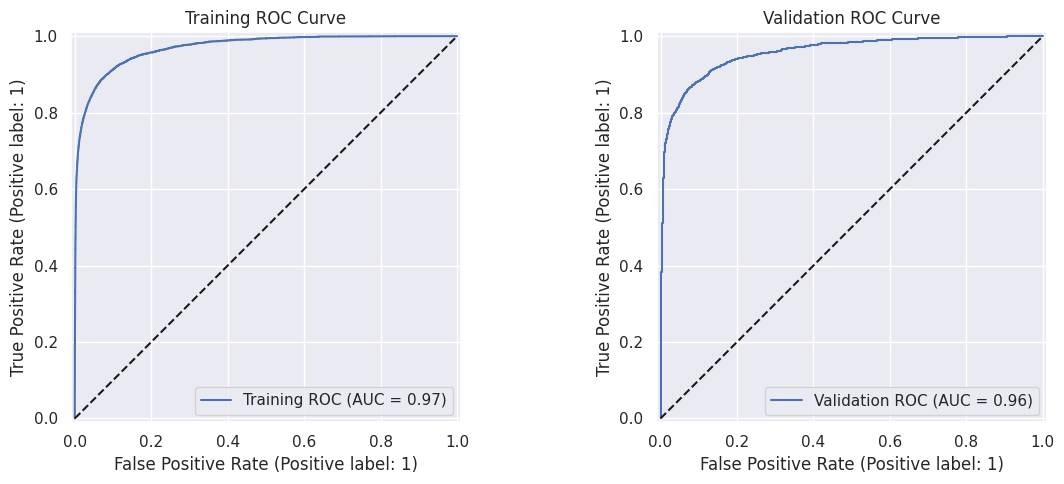

In [86]:
# Train final model with best parameters
best_params = {
    "max_depth": int(best_parameters["max_depth"]),
    "learning_rate": best_parameters["learning_rate"],
    "min_child_weight": best_parameters["min_child_weight"],
    "colsample_bytree": best_parameters["colsample_bytree"],
    "subsample": best_parameters["subsample"],
    "n_estimators": int(best_parameters["n_estimators"]),
    "scale_pos_weight": best_parameters["scale_pos_weight"],
    "enable_categorical": True,
    "early_stopping_rounds": 20,
    "eval_metric": 'auc'
}

final_model = XGBClassifier(**best_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=False
)

# Print final model performance
train_proba = final_model.predict_proba(X_train)[:, 1]
valid_proba = final_model.predict_proba(X_valid)[:, 1]

print("\nFinal model performance:")
print(f"Training AUC-ROC: {roc_auc_score(y_train, train_proba):.4f}")
print(f"Validation AUC-ROC: {roc_auc_score(y_valid, valid_proba):.4f}")

# Optional: Plot ROC curve for final model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(
    y_train,
    train_proba,
    ax=ax1,
    name="Training ROC"
)
ax1.plot([0, 1], [0, 1], "k--")
ax1.set_title("Training ROC Curve")

RocCurveDisplay.from_predictions(
    y_valid,
    valid_proba,
    ax=ax2,
    name="Validation ROC"
)
ax2.plot([0, 1], [0, 1], "k--")
ax2.set_title("Validation ROC Curve")

plt.tight_layout()
plt.show()

In [90]:
preds = clf.predict_proba(X_test)[:,1]
test_with_preds = test.assign(loan_status = preds)[["id", TARGET]]
test_with_preds.to_csv(DATA_DIR / "submission4.csv", index=False)

In [91]:
test_with_preds

,id,loan_status
0,58645,0.998118
1,58646,0.015476
2,58647,0.823440
3,58648,0.010030
4,58649,0.023917
...,...,...
39093,97738,0.040468
39094,97739,0.005501
39095,97740,0.005026
39096,97741,0.134739


In [92]:
!kaggle competitions submit -c playground-series-s4e10 -f ../data/submission4.csv -m "Used optimized hyperparameters - with AUC optimization"

100%|█████████████████████████████████████████| 683k/683k [00:01<00:00, 683kB/s]
Successfully submitted to Loan Approval Prediction

In [50]:
initial_submission = pd.read_csv(DATA_DIR / "submission.csv")

In [52]:
initial_submission

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0
...,...,...
39093,97738,0
39094,97739,0
39095,97740,0
39096,97741,0


In [56]:
comparison = (
    initial_submission
        .join(test_with_preds.rename(columns={"loan_status":"new_pred"}).set_index("id"), on="id")
        .assign(same=lambda x: x[TARGET] == x["new_pred"])
)

In [58]:
comparison[~comparison["same"]]

,id,loan_status,new_pred,same
59,58704,1,0,False
165,58810,0,1,False
196,58841,0,1,False
239,58884,0,1,False
246,58891,0,1,False
...,...,...,...,...
38830,97475,1,0,False
38876,97521,1,0,False
38942,97587,1,0,False
38970,97615,1,0,False


In [59]:
comparison[comparison["same"]]

,id,loan_status,new_pred,same
0,58645,1,1,True
1,58646,0,0,True
2,58647,1,1,True
3,58648,0,0,True
4,58649,0,0,True
...,...,...,...,...
39093,97738,0,0,True
39094,97739,0,0,True
39095,97740,0,0,True
39096,97741,0,0,True
